In [1]:
import sys

from scipy.interpolate import interp1d
import jax
import jax.numpy as jnp
import neural_tangents as nt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev, lax, random, vmap
from jax.example_libraries import optimizers
from neural_tangents import stax
from tqdm import tqdm

2025-05-12 23:18:27.276920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747106307.328215  188854 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747106307.344921  188854 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747106307.459602  188854 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747106307.459617  188854 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747106307.459619  188854 computation_placer.cc:177] computation placer alr

In [2]:
cmap = matplotlib.colormaps.get_cmap('tab20')

In [10]:
# Figure 3(a) and 3(b). Sweep over alpha and epsilon.
def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func2(params, X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f

def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2

In [28]:
def frobenius(x):
    eigenval, eigenvec = jax.numpy.linalg.eigh(x)
    frobenius_norm = jnp.sqrt(np.sum(eigenval**2))
    return frobenius_norm

# Alpha

In [16]:
X.shape, Xt.shape

((100, 550), (100, 1000))

In [ ]:
D = 100
P = 550
N = 500
ntk_interval = 100 

X = random.normal(random.PRNGKey(0), (D,P))
Xt = random.normal(random.PRNGKey(1), (D,1000))
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta, Xt)

a = random.normal(random.PRNGKey(0), (N, ))
W = random.normal(random.PRNGKey(0), (N, D))
params = [a, W]

eps = 0.25
eta = 0.5 * N
lamb = 0.0
opt_init, opt_update, get_params = optimizers.sgd(eta)

alphas = [2**(-5),0.25,0.5,1.0,2.0,4.0,8.0,16,32]

all_tr_losses = []
all_te_losses = []
all_acc_tr = []
all_acc_te = []

param_movement = []

for alpha in alphas:
    print(f"alpha: {alpha}")
    def nn_wrapper(params, X):
        return NN_func2(params, X.T, alpha=alpha, eps=0.25)
    
    ntk_fn = nt.empirical_ntk_fn(nn_wrapper, vmap_axes=0, trace_axes=())
    K_0 = ntk_fn(Xt.T, None, params)
    np.save(f"kernels_alpha_sweep/k_0", K_0)

    opt_state = opt_init(params)
    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X, alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * NN_func2(p, X,alpha)) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(60000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            # sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

        if t % ntk_interval == 0:
            K_test = ntk_fn(Xt.T, None, get_params(opt_state))
            sys.stdout.write(f'\r  t: {t} | train loss: {train_loss} | test loss: {test_loss} |frob ||kt-k0||_2: {frobenius(K_test-K_0)}')
            # np.save(f"kernels_alpha_sweep/k_{t}", K_test) 
    all_tr_losses += [tr_losses]
    all_te_losses += [te_losses]
    all_acc_tr += [tr_acc]
    all_acc_te += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement += [  dparam ]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i,alpha in enumerate(alphas[:-1]):
    print(alpha)
    plt.plot(
        jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), 
        jnp.array(all_tr_losses[i]) / all_tr_losses[i][0], 
        '--',  
        color = f'C{i}'
    )
    plt.plot(
        jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), 
        jnp.array(all_te_losses[i]) / all_te_losses[i][0], 
        color = f'C{i}', 
        label = r'$\alpha = 2^{%0.0f}$' % jnp.log2(alpha)
    )

plt.xscale('log')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

alpha: 0.03125
 
  t: 4900 | train loss: 2.2580341465072706e-05 | test loss: 0.0009616861934773624 |frob ||kt-k0||_2: 0.0030914403032511473

# Weight Normalization

In [ ]:
weight_norms = [0.125,0.25,0.5,1.0,2.0]
alpha = 1.0

eta = 0.5 * N
lamb = 0.0

all_tr_losses_w = []
all_te_losses_w = []
all_acc_tr_w = []
all_acc_te_w = []

param_movement_w = []

for i, wscale in enumerate(weight_norms):
    a = wscale * random.normal(random.PRNGKey(0), (N, ))
    W = wscale * random.normal(random.PRNGKey(0), (N, D))
    params = [a, W]

    opt_init, opt_update, get_params = optimizers.sgd( eta / wscale**2 )
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(50000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses_w += [tr_losses]
    all_te_losses_w += [te_losses]
    all_acc_tr_w += [tr_acc]
    all_acc_te_w += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum(params[0]**2) + jnp.sum(params[1]**2) )
    param_movement_w += [  dparam ]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i, wscale in enumerate(weight_norms):
    print(alpha)
    plt.plot(
        jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), 
        jnp.array(all_tr_losses_w[i]) / all_tr_losses_w[i][0], 
        '--',  
        color = f'C{i}'
    )
    plt.plot(
        jnp.linspace(1,len(all_tr_losses_w[i]),len(all_tr_losses_w[i])), 
        jnp.array(all_te_losses_w[i]) / all_te_losses_w[i][0],  
        color = f'C{i}', 
        label = r'$\sigma = 2^{%0.0f}$' % jnp.log2(wscale)
    )

plt.xscale('log')
plt.xlabel('t',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

# Epsilon

 
  t: 9900 | train loss: 0.0028801646549254656 | test loss: 0.07288174331188202 |frob ||kt-k0||_F: 0.08413097262382507 
  t: 19900 | train loss: 0.0009458101121708751 | test loss: 0.030143799260258675 |frob ||kt-k0||_F: 0.08967255800962448 
  t: 29900 | train loss: 0.0004962695529684424 | test loss: 0.017637422308325768 |frob ||kt-k0||_F: 0.09201108664274216 
  t: 39900 | train loss: 0.00031404380570165813 | test loss: 0.011945870704948902 |frob ||kt-k0||_F: 0.09334668517112732 
  t: 49900 | train loss: 0.00021996871510054916 | test loss: 0.008779174648225307 |frob ||kt-k0||_F: 0.09422557055950165 
  t: 59900 | train loss: 0.00016424685600213706 | test loss: 0.006798961199820042 |frob ||kt-k0||_F: 0.094854153692722324

/tmp/ipykernel_188854/3767731452.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


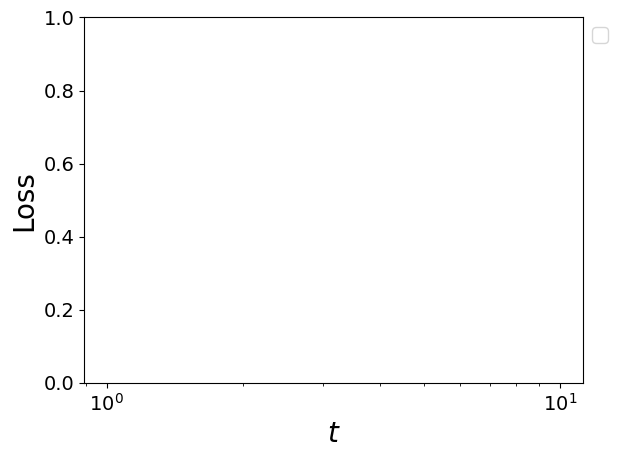

In [39]:
D = 100
P = 550
N = 500
ntk_interval = 100 

X = random.normal(random.PRNGKey(0), (D,P))
Xt = random.normal(random.PRNGKey(1), (D,1000))
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta, Xt)

a = random.normal(random.PRNGKey(0), (N, ))
W = random.normal(random.PRNGKey(0), (N, D))
params = [a, W]

alpha=1.0
eta = 0.5 * N
lamb = 0.0
opt_init, opt_update, get_params = optimizers.sgd(eta)

epsilons = [2**(-2)]#,2**(-1),1,2,4]

all_tr_losses_eps = []
all_te_losses_eps = []
all_acc_tr_eps = []
all_acc_te_eps = []

param_movement = []

for eps in epsilons:
    def nn_wrapper(params, X):
        return NN_func2(params, X.T, alpha=alpha, eps=eps)
    
    ntk_fn = nt.empirical_ntk_fn(nn_wrapper, vmap_axes=0, trace_axes=())
    K_0 = ntk_fn(Xt.T, None, params)
    np.save(f"kernels_eps_sweep/k_0", K_0)

    opt_state = opt_init(params)
    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X, alpha=alpha, eps=eps) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * NN_func2(p, X, alpha=alpha, eps=eps)) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(60000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            # sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

        if t % ntk_interval == 0:
            K_test = ntk_fn(Xt.T, None, get_params(opt_state))
            sys.stdout.write(f'\r  t: {t} | train loss: {train_loss} | test loss: {test_loss} |frob ||kt-k0||_F: {frobenius(K_test-K_0)}')
            # np.save(f"kernels_eps_sweep/k_{t}", K_test) 
    all_tr_losses_eps += [tr_losses]
    all_te_losses_eps += [te_losses]
    all_acc_tr_eps += [tr_acc]
    all_acc_te_eps += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement += [dparam]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i, eps in enumerate(epsilons[:-1]):
    plt.plot(
        jnp.linspace(1,len(all_tr_losses_eps[i]),len(all_tr_losses_eps[i])), 
        jnp.array(all_tr_losses_eps[i]) / all_tr_losses_eps[i][0], 
        '--',  
        color = f'C{i}'
    )
    plt.plot(
        jnp.linspace(1,len(all_tr_losses_eps[i]),len(all_tr_losses_eps[i])), 
        jnp.array(all_te_losses_eps[i]) / all_te_losses_eps[i][0],  
        color = f'C{i}', 
        label = r'$\alpha = 2^{%0.0f}$' % jnp.log2(alpha)
    )

plt.xscale('log')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()